## Imports

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Original shape: (480, 640)

Pixel displacement:
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0 55 39 39 39 39 39 39 39 39 56 56 39 39 39 56
 56 56 39 39 39 39 39 39 56 56 56 55 55 55 55 55 55 55 55 55 55 55 56 56
 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 57 57 57 57 57 57 57 57
 39 57 57 57 57 57 57 57 57 57 39 39 58 58 39 40 39 3

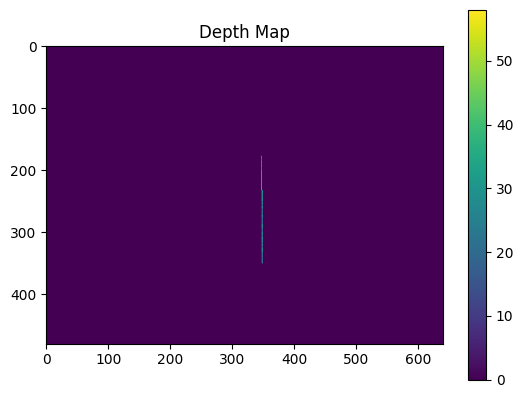

Points:
[[ 3.24940061 -7.58193475 55.        ]
 [ 2.30412043 -5.29094321 39.        ]
 [ 2.30412043 -5.20560542 39.        ]
 [ 2.30412043 -5.12026762 39.        ]
 [ 2.30412043 -5.03492983 39.        ]
 [ 2.30412043 -4.94959204 39.        ]
 [ 2.30412043 -4.86425424 39.        ]
 [ 2.30412043 -4.77891645 39.        ]
 [ 2.30412043 -4.69357865 39.        ]
 [ 3.30848062 -6.61696124 56.        ]
 [ 3.30848062 -6.49442492 56.        ]
 [ 2.30412043 -4.43756527 39.        ]
 [ 2.30412043 -4.35222748 39.        ]
 [ 2.30412043 -4.26688969 39.        ]
 [ 3.30848062 -6.00427964 56.        ]
 [ 3.30848062 -5.88174332 56.        ]
 [ 3.30848062 -5.759207   56.        ]
 [ 2.30412043 -3.92553851 39.        ]
 [ 2.30412043 -3.84020072 39.        ]
 [ 2.30412043 -3.75486292 39.        ]
 [ 2.30412043 -3.66952513 39.        ]
 [ 2.30412043 -3.58418734 39.        ]
 [ 2.30412043 -3.49884954 39.        ]
 [ 3.30848062 -4.90145277 56.        ]
 [ 3.30848062 -4.77891645 56.        ]
 [ 3.30848062 -4.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
from scipy.optimize import curve_fit
from scipy.interpolate import CubicSpline, interp1d
from video_test import extract_frames
from camera_calibration import getCameraCalibrationValues
from utils import getPointClouds
from mpl_toolkits.mplot3d import Axes3D
import os
import glob
import warnings


## Math functions

In [2]:
class Colors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'  # Resets the color to default


In [3]:
def getSobelXGradient(frame):
    sobelX = cv2.Sobel(frame, cv2.CV_64F, 1, 0)
    return sobelX

def getIntensityIndexOuterEdge(y_values):
    # print("Y values")
    # print(abs(y_values))
    x_values = np.arange(len(y_values))

    # Define the Gaussian function
    def gaussian(x, amplitude, mean, stddev):
        return amplitude * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))

    # Initial guess for the parameters: amplitude, mean, stddev
    initial_guess = [max(y_values), np.argmax(y_values), 1]

    # Perform the curve fitting
    try:
        params, covariance = curve_fit(gaussian, x_values, y_values, p0=initial_guess, maxfev=10000)
    except RuntimeError as e:
        print(f"{Colors.FAIL}Curve fitting failed: {e}{Colors.ENDC}")
        return np.argmax(y_values)

    # Extract the fitted parameters
    fitted_amplitude, fitted_mean, fitted_stddev = params

    # Find the index closest to the mean
    closest_index = np.argmin(np.round(np.abs(x_values - fitted_mean)))
    # print("Closest index to the mean:", closest_index)

    # Plot the original data and the fitted Gaussian curve
    # plt.plot(x_values, y_values, 'b-', label='data')
    # plt.plot(x_values, gaussian(x_values, *params), 'r--', label='fit: mean=%5.3f' % fitted_mean)
    # plt.axvline(x=fitted_mean, color='g', linestyle='--', label='Mean (µ)')
    # plt.axvline(x=closest_index, color='m', linestyle='--', label='Closest Index')
    # plt.xlabel('Index')
    # plt.ylabel('Y-values')
    # plt.legend()
    # plt.show()
    return closest_index

def getIntensityIndexInnerEdge(y_values):
    y_values = -(y_values)
    # print("Y values")
    # print(abs(y_values))
    x_values = np.arange(len(y_values))

    # Define the Gaussian function
    def gaussian(x, amplitude, mean, stddev):
        return amplitude * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))

    # Initial guess for the parameters: amplitude, mean, stddev
    initial_guess = [max(y_values), np.argmax(y_values), 1]

    # Perform the curve fitting
    try:
        params, covariance = curve_fit(gaussian, x_values, y_values, p0=initial_guess, maxfev=10000)
    except RuntimeError as e:
        print(f"{Colors.FAIL}Curve fitting failed: {e}{Colors.ENDC}")
        return np.argmax(y_values)

    # Extract the fitted parameters
    fitted_amplitude, fitted_mean, fitted_stddev = params

    # Find the index closest to the mean
    closest_index = np.argmin(np.round(np.abs(x_values - fitted_mean)))
    # print("Closest index to the mean:", closest_index)

    # Plot the original data and the fitted Gaussian curve
    # plt.plot(x_values, y_values, 'b-', label='data')
    # plt.plot(x_values, gaussian(x_values, *params), 'r--', label='fit: mean=%5.3f' % fitted_mean)
    # plt.axvline(x=fitted_mean, color='g', linestyle='--', label='Mean (µ)')
    # plt.axvline(x=closest_index, color='m', linestyle='--', label='Closest Index')
    # plt.xlabel('Index')
    # plt.ylabel('Y-values')
    # plt.legend()
    # plt.show()
    return closest_index



In [4]:
# Reference Line interpolation

def split_groups_polynomial(values, threshold, degree=3):
    
    high_values = []
    maxReference = np.max(values)
    for i in values:
        if i >= (maxReference - threshold):
            high_values.append(i)
            
    group1 = []
    group2 = []
    high_values_set = set(high_values)
    used_high_values = set()
    
    for value in values:
        if value in high_values_set:
            group1.append(value)
            group2.append(None)
            used_high_values.add(value)
        else:
            group1.append(None)
            group2.append(value)
    
    known_indices = [i for i, x in enumerate(group1) if x is not None]
    known_values = [x for x in group1 if x is not None]
    
    try:
        with warnings.catch_warnings(record=True) as w:
            warnings.simplefilter('always', np.RankWarning)
            
            poly_coeffs = np.polyfit(known_indices, known_values, degree)
            
            if len(w) > 0 and issubclass(w[-1].category, np.RankWarning):
                print("RankWarning: Polyfit may be poorly conditioned")
                # Handle the poorly conditioned case
                return None, group2
            
        poly_interp = np.poly1d(poly_coeffs)
        interp_values = np.round(poly_interp(range(len(group1)))).astype(int)
        
    except Exception as e:
        print(f"An error occurred during polynomial fitting: {e}")
        return None, group2
    
    # poly_interp = np.poly1d(np.polyfit(known_indices, known_values, degree))
    # interp_values = np.round(poly_interp(range(len(group1)))).astype(int)
    
    group1 = [interp_values[i] if x is None else x for i, x in enumerate(group1)]
    
    return group1, group2

In [5]:
# Depth Map for individual frames

def getDepthMap(frame, referenceLine, heightValues):
    depthMap = np.zeros(frame.shape)
    for i in range(frame.shape[0]):
        # print(f"{Colors.OKBLUE}({i}, {referenceLine[i]}, {heightValues[i]})")
        depthMap[i][int(referenceLine[i])] = heightValues[i]
    return depthMap

In [6]:
# Camera Calibration Values
pixels_per_mm, cameraMatrix, dist, rvecs, tvecs = getCameraCalibrationValues()

Chessboard not found
1 mm = 10.627679228349166 pixels
Camera calibrated : 
 0.34352429263843676
Camera Matrix : 
 [[6.29530966e+03 0.00000000e+00 3.31140037e+02]
 [0.00000000e+00 6.36133646e+03 2.73235766e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
dist : 
 [[ 1.91572262e+01 -6.30755414e+03  2.78251225e-02  1.09198287e-02
  -2.47159800e+01]]
Rotation Vectors : 
 (array([[ 0.13408516],
       [-0.02418959],
       [-0.0025449 ]]), array([[-0.14921689],
       [ 0.07300657],
       [ 0.63636061]]), array([[-0.14169744],
       [ 0.08726113],
       [ 1.24802589]]), array([[-0.13515006],
       [ 0.08980708],
       [ 1.56805538]]), array([[0.12102242],
       [0.02120187],
       [0.46410927]]), array([[ 0.12186551],
       [-0.05546391],
       [ 0.98851071]]), array([[ 0.10437124],
       [-0.10527939],
       [ 1.34445345]]), array([[ 0.10135235],
       [-0.10412304],
       [ 1.49746484]]), array([[-0.13640589],
       [ 0.06773318],
       [ 0.62056035]]), array([[ 0.1136

In [7]:
# Get Point Clouds from Depth Map and Camera Intrinsic Matrix

def getPointClouds(depthMap, cameraIntrinsic):
    height, width = depthMap.shape
    points = []

    fx, fy = cameraIntrinsic[0, 0], cameraIntrinsic[1, 1]
    cx, cy = cameraIntrinsic[0, 2], cameraIntrinsic[1, 2]

    for v in range(height):
        for u in range(width):
            Z = depthMap[v, u]
            if Z == 0:  # Skip invalid depth values
                continue
            X = (u - cx) * Z / fx
            Y = (v - cy) * Z / fy
            points.append([X, Y, Z])

    points = np.array(points)
    # print(f"{Colors.FAIL}Points:{Colors.ENDC}")
    # print(points)
    
    # Create point cloud
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)

    return pcd

## Utilities function

In [8]:
## Visualize the depth map in 3D

def visualize_depth_map_3d(depth_map):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    x = np.linspace(0, depth_map.shape[1], depth_map.shape[1])
    y = np.linspace(0, depth_map.shape[0], depth_map.shape[0])
    x, y = np.meshgrid(x, y)

    ax.plot_surface(x, y, depth_map, cmap='viridis')

    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Depth')

    plt.show()

In [9]:
## Draw edge trace on the frame

def drawEdgeTrace(objectName, edgeTrace, intensityInnerEdge, intensityOuterEdge, meanIndex, referenceLine, count):
    # Convert the Sobel gradient image to absolute values to fit into the 8-bit range
    edgeTraceAbs = np.abs(edgeTrace).astype(np.uint8)
    
    # Convert the grayscale edgeTrace to BGR color image
    edgeTraceColor = cv2.cvtColor(edgeTraceAbs, cv2.COLOR_GRAY2BGR)
    
    # Define the output folder and create it if it doesn't exist
    output_folder = f'./edge_trace/{objectName}/'
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

     
    # Plot the intensity points on the edgeTraceColor image
    if intensityInnerEdge is not None:
        for idx, val in enumerate(intensityInnerEdge):
            cv2.circle(edgeTraceColor, (int(val), int(idx)), 1, (255, 0, 0), -1)  # Blue dot with radius 1

    if intensityOuterEdge is not None:
        for idx, val in enumerate(intensityOuterEdge):
            cv2.circle(edgeTraceColor, (int(val), int(idx)), 1, (0, 0, 255), -1)  # Red dot with radius 1
    if meanIndex is not None:
        for idx, val in enumerate(meanIndex):
            cv2.circle(edgeTraceColor, (int(val), int(idx)), 1, (0, 255, 255), -1)  # Yellow dot with radius 1
    if referenceLine is not None:    
        for idx, val in enumerate(referenceLine):
            cv2.circle(edgeTraceColor, (int(val), int(idx)), 1, (0, 255, 0), -1)  # Green dot with radius 1

    # Save the image with the plotted points
    cv2.imwrite(f"./edge_trace/{objectName}/frame{count}.jpg", edgeTraceColor)

In [10]:
## Draw the depth map for a frame
def drawDepthMapFrame(depthMapFrame, obejctName, count):
    output_folder = f'./depth_maps/{objectName}/'
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # Create a figure and axis
    fig, ax = plt.subplots()
    # Display the depth map
    cax = ax.imshow(depthMapFrame)
    # Add a color bar
    fig.colorbar(cax, ax=ax)
    # Save the figure
    plt.savefig(f"{output_folder}/frame{count}.jpg")
    # Close the figure to free up memory
    plt.close(fig)

## Experiment

In [11]:
# # REFERENCE FRAME
# objectName = "reference_03"
# objectFrames = extract_frames(objectName, ".mp4")

# mean_reference = []
# count = 0

# # Loop through the frames
# for frame in objectFrames:
#     # Get the Sobel X gradient
#     # print(f"Processing frame {frame.shape}...")
#     edgeTrace = getSobelXGradient(frame)

#     # Calculate intensity index
#     intensityInnerEdge = np.round(np.array([getIntensityIndexInnerEdge(i) for i in edgeTrace]))
#     intensityOuterEdge = np.round(np.array([getIntensityIndexOuterEdge(i) for i in edgeTrace]))
#     meanIndex = np.round((intensityInnerEdge + intensityOuterEdge) / 2)
#     # print("Intensity Indices:")
#     # print(intensity)

#     # Convert the Sobel gradient image to absolute values to fit into the 8-bit range
#     edgeTraceAbs = np.abs(edgeTrace).astype(np.uint8)
    
#     # Convert the grayscale edgeTrace to BGR color image
#     edgeTraceColor = cv2.cvtColor(edgeTraceAbs, cv2.COLOR_GRAY2BGR)

#     # Define the output folder and create it if it doesn't exist
#     output_folder = f'./edge_trace/{objectName}/'
#     if not os.path.exists(output_folder):
#         os.makedirs(output_folder)
    
#     # Plot the intensity points on the edgeTraceColor image
#     for idx, val in enumerate(intensityInnerEdge):
#         cv2.circle(edgeTraceColor, (int(val), int(idx)), 1, (255, 0, 0), -1)  # Blue dot with radius 1

#     for idx, val in enumerate(intensityOuterEdge):
#         cv2.circle(edgeTraceColor, (int(val), int(idx)), 1, (0, 0, 255), -1)  # Red dot with radius 1

#     for idx, val in enumerate(meanIndex):
#         cv2.circle(edgeTraceColor, (int(val), int(idx)), 1, (0, 255, 255), -1)  # Red dot with radius 1

#     # Save the image with the plotted points
#     cv2.imwrite(f"./edge_trace/{objectName}/frame{count}.jpg", edgeTraceColor)
#     mean_reference.append(abs(np.max(meanIndex) - np.min(meanIndex)))
    
#     count += 1
#     # break  # Remove this break to process all frames

# # mean_reference = np.mean(mean_reference, axis=0)
# # print(f"{Colors.OKGREEN}Mean Reference Indices:{Colors.ENDC}")
# # print(mean_reference)
# print(f"{Colors.OKGREEN}Deva of Reference Indices:{Colors.ENDC}")
# print(mean_reference)

In [28]:
#OBJECT HEIGHT MEASUREMENT

# Define the object name and extract frames
objectName = "1mmblackcube"
# objectFrames = extract_frames(objectName, ".mp4")

meanPixelDisplacement = []
count = 0

heightList = []
all_point_clouds = []

# Define the translation distance between frames in mm
translation_distance = 0.75

objectFrames = glob.glob(f"./{objectName}/*.jpg")

depthMap = []
referenceLineList = []
# Loop through the frames
for image in objectFrames:
    print(f"Processing frame {image}...")
    frame = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    
    # Get the Sobel X gradient
    edgeTrace = getSobelXGradient(frame)

    # Calculate intensity index along the laser edge trace
    intensityInnerEdge = np.round(np.array([getIntensityIndexInnerEdge(i) for i in edgeTrace]))
    intensityOuterEdge = np.round(np.array([getIntensityIndexOuterEdge(i) for i in edgeTrace]))
    meanIndex = np.round((intensityInnerEdge + intensityOuterEdge) / 2)

    
    # print(f"{Colors.OKGREEN}Mean Index:{Colors.ENDC}")
    # print(meanIndex)
    c = pixels_per_mm
    referenceLine, _ = split_groups_polynomial(meanIndex, c/2)
    
   
    drawEdgeTrace(objectName, edgeTrace, intensityInnerEdge, intensityOuterEdge, meanIndex, referenceLine, count)
    
    if referenceLine is None:
        print(f"{Colors.FAIL}Reference line not found{Colors.ENDC}")
        heights = depthMap[-1]
        referenceLine = referenceLineList[-1]
    else:
        pixelDisplacement = abs(meanIndex - referenceLine)
        c = pixels_per_mm
        s = pixelDisplacement / c
        heights = 80 * s / (37.3 + s)

    depthMap.append(heights)
    referenceLineList.append(referenceLine)

    # Depth map for individual frames
    depthMapFrame = getDepthMap(frame, referenceLine, heights)
    drawDepthMapFrame(depthMapFrame, objectName, count)

    count += 1
    # break  # Remove this break to process all frames

Processing frame ./1mmblackcube\Snap_113.jpg...
Processing frame ./1mmblackcube\Snap_114.jpg...
Processing frame ./1mmblackcube\Snap_115.jpg...
Processing frame ./1mmblackcube\Snap_116.jpg...
Processing frame ./1mmblackcube\Snap_117.jpg...
Processing frame ./1mmblackcube\Snap_118.jpg...
Processing frame ./1mmblackcube\Snap_119.jpg...
Processing frame ./1mmblackcube\Snap_120.jpg...
Processing frame ./1mmblackcube\Snap_121.jpg...
Processing frame ./1mmblackcube\Snap_122.jpg...
Processing frame ./1mmblackcube\Snap_123.jpg...
Processing frame ./1mmblackcube\Snap_124.jpg...
Processing frame ./1mmblackcube\Snap_125.jpg...
Processing frame ./1mmblackcube\Snap_126.jpg...
Processing frame ./1mmblackcube\Snap_127.jpg...
Processing frame ./1mmblackcube\Snap_128.jpg...
Processing frame ./1mmblackcube\Snap_129.jpg...
Processing frame ./1mmblackcube\Snap_130.jpg...
Processing frame ./1mmblackcube\Snap_131.jpg...
Processing frame ./1mmblackcube\Snap_132.jpg...
Processing frame ./1mmblackcube\Snap_133

c:\Users\Anugrah\OneDrive\Desktop\Anugrah Personal\Uof Glasgow\MSc Project\MSC_Proj\3D_Scanner_Laser_Triangulation\env\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Reference line not found
Processing frame ./1mmblackcube\Snap_138.jpg...


c:\Users\Anugrah\OneDrive\Desktop\Anugrah Personal\Uof Glasgow\MSc Project\MSC_Proj\3D_Scanner_Laser_Triangulation\env\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
c:\Users\Anugrah\OneDrive\Desktop\Anugrah Personal\Uof Glasgow\MSc Project\MSC_Proj\3D_Scanner_Laser_Triangulation\env\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T


Reference line not found
Processing frame ./1mmblackcube\Snap_139.jpg...


c:\Users\Anugrah\OneDrive\Desktop\Anugrah Personal\Uof Glasgow\MSc Project\MSC_Proj\3D_Scanner_Laser_Triangulation\env\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
c:\Users\Anugrah\OneDrive\Desktop\Anugrah Personal\Uof Glasgow\MSc Project\MSC_Proj\3D_Scanner_Laser_Triangulation\env\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T


Reference line not found
Processing frame ./1mmblackcube\Snap_140.jpg...


c:\Users\Anugrah\OneDrive\Desktop\Anugrah Personal\Uof Glasgow\MSc Project\MSC_Proj\3D_Scanner_Laser_Triangulation\env\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Reference line not found
Processing frame ./1mmblackcube\Snap_141.jpg...


c:\Users\Anugrah\OneDrive\Desktop\Anugrah Personal\Uof Glasgow\MSc Project\MSC_Proj\3D_Scanner_Laser_Triangulation\env\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Reference line not found
Processing frame ./1mmblackcube\Snap_142.jpg...


c:\Users\Anugrah\OneDrive\Desktop\Anugrah Personal\Uof Glasgow\MSc Project\MSC_Proj\3D_Scanner_Laser_Triangulation\env\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Reference line not found
Processing frame ./1mmblackcube\Snap_143.jpg...


c:\Users\Anugrah\OneDrive\Desktop\Anugrah Personal\Uof Glasgow\MSc Project\MSC_Proj\3D_Scanner_Laser_Triangulation\env\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
c:\Users\Anugrah\OneDrive\Desktop\Anugrah Personal\Uof Glasgow\MSc Project\MSC_Proj\3D_Scanner_Laser_Triangulation\env\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T


Reference line not found
Processing frame ./1mmblackcube\Snap_144.jpg...


c:\Users\Anugrah\OneDrive\Desktop\Anugrah Personal\Uof Glasgow\MSc Project\MSC_Proj\3D_Scanner_Laser_Triangulation\env\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Processing frame ./1mmblackcube\Snap_145.jpg...
Processing frame ./1mmblackcube\Snap_146.jpg...
Processing frame ./1mmblackcube\Snap_147.jpg...
Processing frame ./1mmblackcube\Snap_148.jpg...
Processing frame ./1mmblackcube\Snap_149.jpg...


c:\Users\Anugrah\OneDrive\Desktop\Anugrah Personal\Uof Glasgow\MSc Project\MSC_Proj\3D_Scanner_Laser_Triangulation\env\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Processing frame ./1mmblackcube\Snap_150.jpg...
Processing frame ./1mmblackcube\Snap_151.jpg...
Processing frame ./1mmblackcube\Snap_152.jpg...
Processing frame ./1mmblackcube\Snap_153.jpg...
Processing frame ./1mmblackcube\Snap_154.jpg...


c:\Users\Anugrah\OneDrive\Desktop\Anugrah Personal\Uof Glasgow\MSc Project\MSC_Proj\3D_Scanner_Laser_Triangulation\env\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Processing frame ./1mmblackcube\Snap_155.jpg...
Processing frame ./1mmblackcube\Snap_156.jpg...


c:\Users\Anugrah\OneDrive\Desktop\Anugrah Personal\Uof Glasgow\MSc Project\MSC_Proj\3D_Scanner_Laser_Triangulation\env\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Processing frame ./1mmblackcube\Snap_157.jpg...
Processing frame ./1mmblackcube\Snap_158.jpg...


c:\Users\Anugrah\OneDrive\Desktop\Anugrah Personal\Uof Glasgow\MSc Project\MSC_Proj\3D_Scanner_Laser_Triangulation\env\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Processing frame ./1mmblackcube\Snap_159.jpg...


c:\Users\Anugrah\OneDrive\Desktop\Anugrah Personal\Uof Glasgow\MSc Project\MSC_Proj\3D_Scanner_Laser_Triangulation\env\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Processing frame ./1mmblackcube\Snap_160.jpg...
Processing frame ./1mmblackcube\Snap_161.jpg...
Processing frame ./1mmblackcube\Snap_162.jpg...
Processing frame ./1mmblackcube\Snap_163.jpg...
Processing frame ./1mmblackcube\Snap_164.jpg...
Processing frame ./1mmblackcube\Snap_165.jpg...
Processing frame ./1mmblackcube\Snap_166.jpg...
Processing frame ./1mmblackcube\Snap_167.jpg...
Processing frame ./1mmblackcube\Snap_168.jpg...
Processing frame ./1mmblackcube\Snap_169.jpg...
Processing frame ./1mmblackcube\Snap_170.jpg...
Processing frame ./1mmblackcube\Snap_171.jpg...
Processing frame ./1mmblackcube\Snap_172.jpg...
Processing frame ./1mmblackcube\Snap_173.jpg...
Processing frame ./1mmblackcube\Snap_174.jpg...
Processing frame ./1mmblackcube\Snap_175.jpg...


In [85]:
depthMapCopy = depthMap.copy()
test = depthMap.copy()[-1]
depthMapCopy.append(test)
# print(test)

(64, 480)


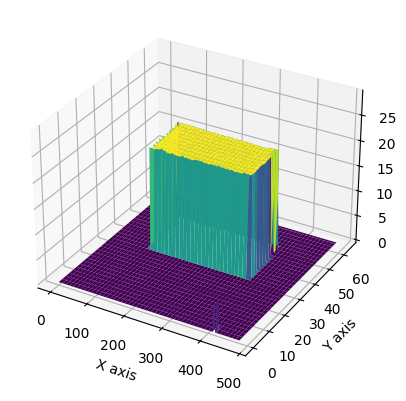

In [86]:
depthMapCopy = np.array(depthMapCopy)
print(depthMapCopy.shape)
visualize_depth_map_3d(depthMapCopy)

In [91]:
len(depthMapCopy)

64

In [92]:
# dFrame = np.zeros((480, 640))
dFrame = []
for i in range(len(depthMapCopy)):
    for j in range(i, i+10):
        dFrame.append(depthMapCopy[i])

In [112]:
dFrame = np.array(dFrame)
dFrame = dFrame.T
print(dFrame.shape)

(480, 640)


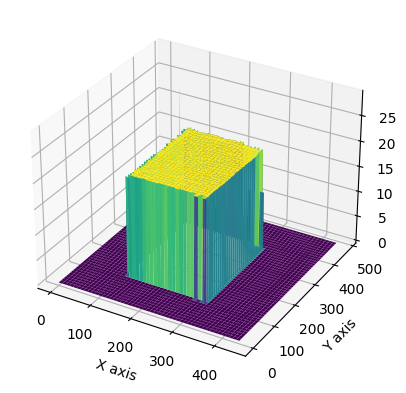

In [113]:
# visualize_depth_map_3d(dFrame[:, 25:60])
visualize_depth_map_3d(dFrame[:, 200:])

In [89]:
frame = cv2.imread("./1mmblackcube/Reference/Snap_113.jpg", cv2.IMREAD_GRAYSCALE)
pcd = getPointClouds(dFrame, cameraMatrix)
# Visualize point cloud
o3d.visualization.draw_geometries([pcd])

In [90]:
# Compute normals for the combined point cloud
print("Computing normals for the combined point cloud...")
combined_pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))

# Perform surface reconstruction using Poisson reconstruction
print("Performing surface reconstruction...")
mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(combined_pcd, depth=9)

# Optionally, remove low-density vertices to clean up the mesh
vertices_to_remove = densities < np.quantile(densities, 0.01)
mesh.remove_vertices_by_mask(vertices_to_remove)

# Save and visualize the mesh
mesh_folder = f'./meshes/'
if not os.path.exists(mesh_folder):
    os.makedirs(mesh_folder)
o3d.io.write_triangle_mesh(f'{mesh_folder}/{objectName}.ply', mesh)
o3d.visualization.draw_geometries([mesh])

Computing normals for the combined point cloud...


NameError: name 'combined_pcd' is not defined